In [194]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import random
from sklearn.preprocessing import MinMaxScaler

### References

- [Agglomerative Hierarchical Clustering in Python with Scikit-Learn](https://stackabuse.com/bytes/agglomerative-hierarchical-clustering-with-scikit-learn/)
- [K-Means Clustering in Python: A Practical Guide](https://realpython.com/k-means-clustering-python/#hierarchical-clustering)
- [Hierarchical Clustering](https://realpython.com/k-means-clustering-python/#hierarchical-clustering)
- [Definitive Guide to Hierarchical Clustering with Python and Scikit-Learn](https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/)
- [Hierarchical Agglomerative Clustering Algorithm Example In Python](https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019)

## Data Dictionary

The raw dataset consists of 21 unique features and 1,048,576 unique patients. 
**In the Boolean features, 1 means "yes" and 2 means "no". Values as 97 and 99 are missing data.**

 - sex: 1 for female and 2 for male.
 - age: of the patient.
 - classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different degrees. 
   4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
 - patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
 - pneumonia: whether the patient already have air sacs inflammation or not.
 - pregnancy: whether the patient is pregnant or not.
 - diabetes: whether the patient has diabetes or not.
 - copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
 - asthma: whether the patient has asthma or not.
 - inmsupr: whether the patient is immunosuppressed or not.
 - hypertension: whether the patient has hypertension or not.
 - cardiovascular: whether the patient has heart or blood vessels related disease.
 - renal chronic: whether the patient has chronic renal disease or not.
 - other disease: whether the patient has other disease or not.
 - obesity: whether the patient is obese or not.
 - tobacco: whether the patient is a tobacco user.
 - usmr: Indicates whether the patient treated medical units of the first, second or third level.
 - medical unit: type of institution of the National Health System that provided the care.
 - intubed: whether the patient was connected to the ventilator.
 - icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
- date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.

In [195]:
df_covid = pd.read_csv('../dataset/datacovid.csv')
df_covid

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,9999-99-99,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


As we know values having 97, 98 or 99 are considered as null and as per above cell, we can see INTUBED, PREGNANT and ICU fields have huge amount of null values. So we will remove the records for other fields and will analyze these three fields seperately

In [196]:
# creating a new cloumn based on the column 'DATE_DIED'
# DATE is e.g. 15/02/2020 - True(Died), otherwise is False(Alive).
df_covid['ALIVE_OR_DIED'] = np.where(df_covid['DATE_DIED']!= '9999-99-99', '0', '1')
df_covid['ALIVE_OR_DIED']

0          0
1          0
2          0
3          0
4          0
          ..
1048570    1
1048571    1
1048572    1
1048573    1
1048574    1
Name: ALIVE_OR_DIED, Length: 1048575, dtype: object

In [197]:
df_covid = df_covid.drop(columns='DATE_DIED') # drop column - DATE_DIED
df_covid['ALIVE_OR_DIED'] = df_covid['ALIVE_OR_DIED'].astype('int64')

In [198]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype
---  ------                --------------    -----
 0   USMER                 1048575 non-null  int64
 1   MEDICAL_UNIT          1048575 non-null  int64
 2   SEX                   1048575 non-null  int64
 3   PATIENT_TYPE          1048575 non-null  int64
 4   INTUBED               1048575 non-null  int64
 5   PNEUMONIA             1048575 non-null  int64
 6   AGE                   1048575 non-null  int64
 7   PREGNANT              1048575 non-null  int64
 8   DIABETES              1048575 non-null  int64
 9   COPD                  1048575 non-null  int64
 10  ASTHMA                1048575 non-null  int64
 11  INMSUPR               1048575 non-null  int64
 12  HIPERTENSION          1048575 non-null  int64
 13  OTHER_DISEASE         1048575 non-null  int64
 14  CARDIOVASCULAR        1048575 non-null  int64
 15  OBESITY        

In [199]:
df_covid.nunique()

USMER                     2
MEDICAL_UNIT             13
SEX                       2
PATIENT_TYPE              2
INTUBED                   4
PNEUMONIA                 3
AGE                     121
PREGNANT                  4
DIABETES                  3
COPD                      3
ASTHMA                    3
INMSUPR                   3
HIPERTENSION              3
OTHER_DISEASE             3
CARDIOVASCULAR            3
OBESITY                   3
RENAL_CHRONIC             3
TOBACCO                   3
CLASIFFICATION_FINAL      7
ICU                       4
ALIVE_OR_DIED             2
dtype: int64

In [200]:
df_covid.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA',
       'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU',
       'ALIVE_OR_DIED'],
      dtype='object')

Text(0.5, 1.0, 'Distribution - Age')

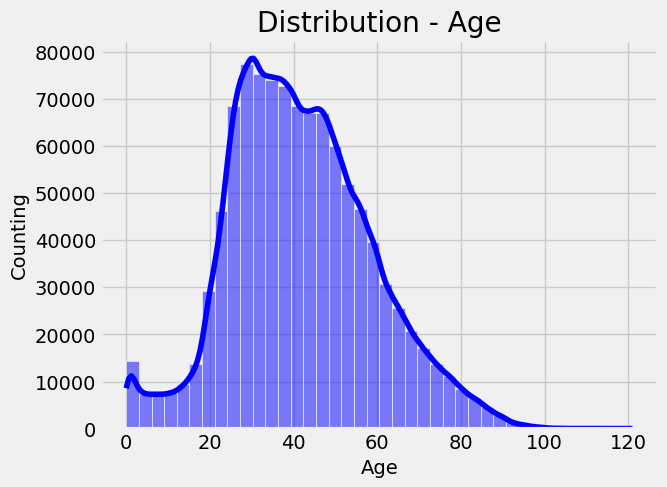

In [201]:
sns.histplot(data=df_covid, x="AGE", bins=40, kde=True, color="blue")
plt.xlabel('Age')
plt.ylabel('Counting')
plt.title('Distribution - Age')

Text(0.5, 1.0, 'Death of the patients according to age')

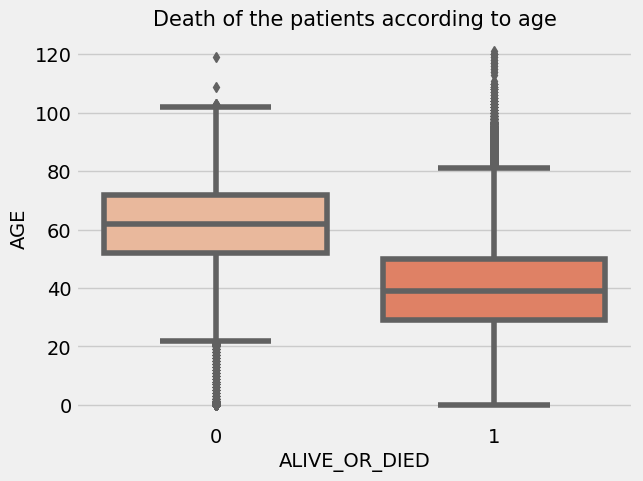

In [202]:
sns.boxplot(x="ALIVE_OR_DIED", y="AGE",data=df_covid,palette=sns.color_palette("rocket_r"))
plt.title("Death of the patients according to age",fontsize=15)

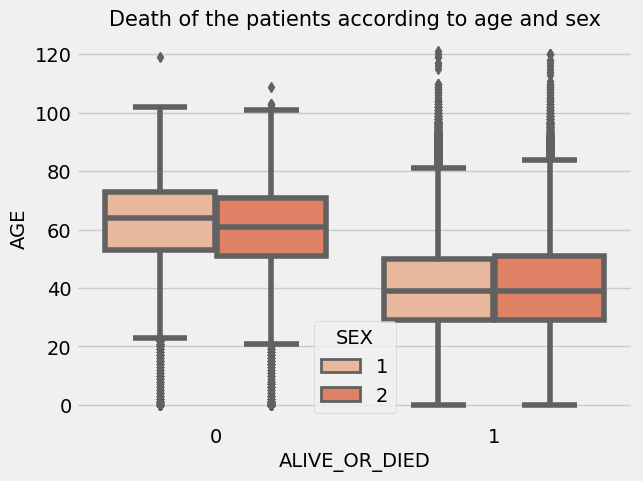

In [203]:
sns.boxplot(x="ALIVE_OR_DIED", y="AGE",data=df_covid,palette=sns.color_palette("rocket_r"), hue='SEX')
plt.title("Death of the patients according to age and sex",fontsize=15);

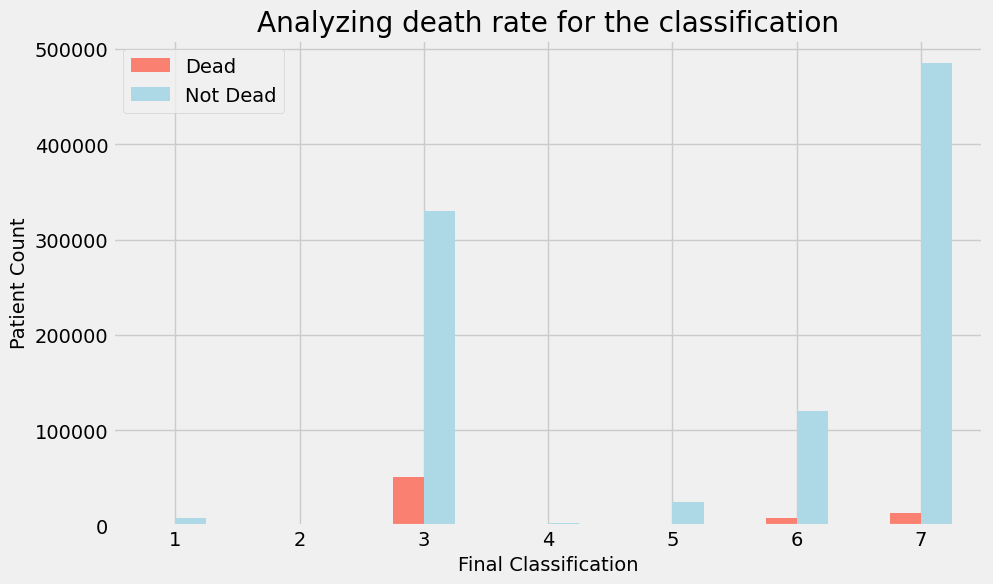

In [204]:
pd.crosstab(df_covid.CLASIFFICATION_FINAL, df_covid.ALIVE_OR_DIED).plot(kind="bar", figsize=(10,6), color=["salmon","lightblue"])
plt.title("Analyzing death rate for the classification")
plt.xlabel("Final Classification")
plt.ylabel("Patient Count")
plt.legend(["Dead", "Not Dead"])
plt.xticks(rotation=0);

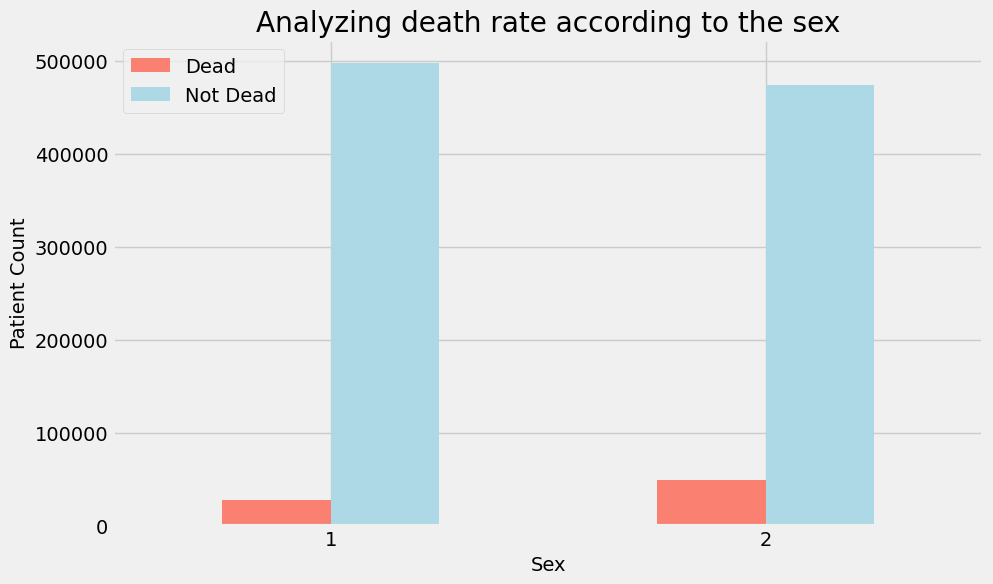

In [205]:
pd.crosstab(df_covid.SEX, df_covid.ALIVE_OR_DIED).plot(kind="bar", figsize=(10,6), color=["salmon","lightblue"])
plt.title("Analyzing death rate according to the sex")
plt.xlabel("Sex")
plt.ylabel("Patient Count")
plt.legend(["Dead", "Not Dead"])
plt.xticks(rotation=0);

(array([0, 1, 2]), [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '98')])

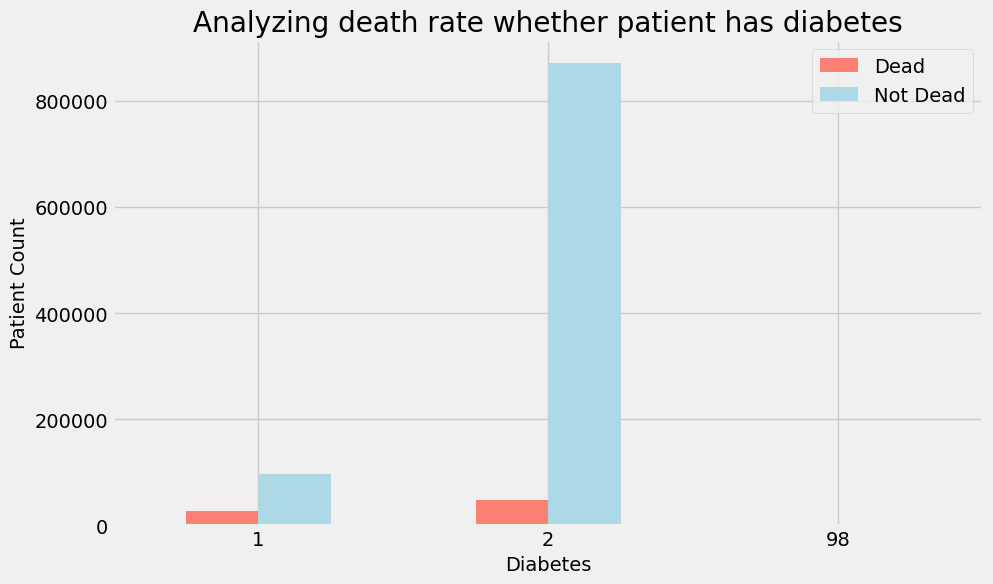

In [206]:
pd.crosstab(df_covid.DIABETES, df_covid.ALIVE_OR_DIED).plot(kind="bar", figsize=(10,6), color=["salmon","lightblue"])
plt.title("Analyzing death rate whether patient has diabetes")
plt.xlabel("Diabetes")
plt.ylabel("Patient Count")
plt.legend(["Dead", "Not Dead"])
plt.xticks(rotation=0)

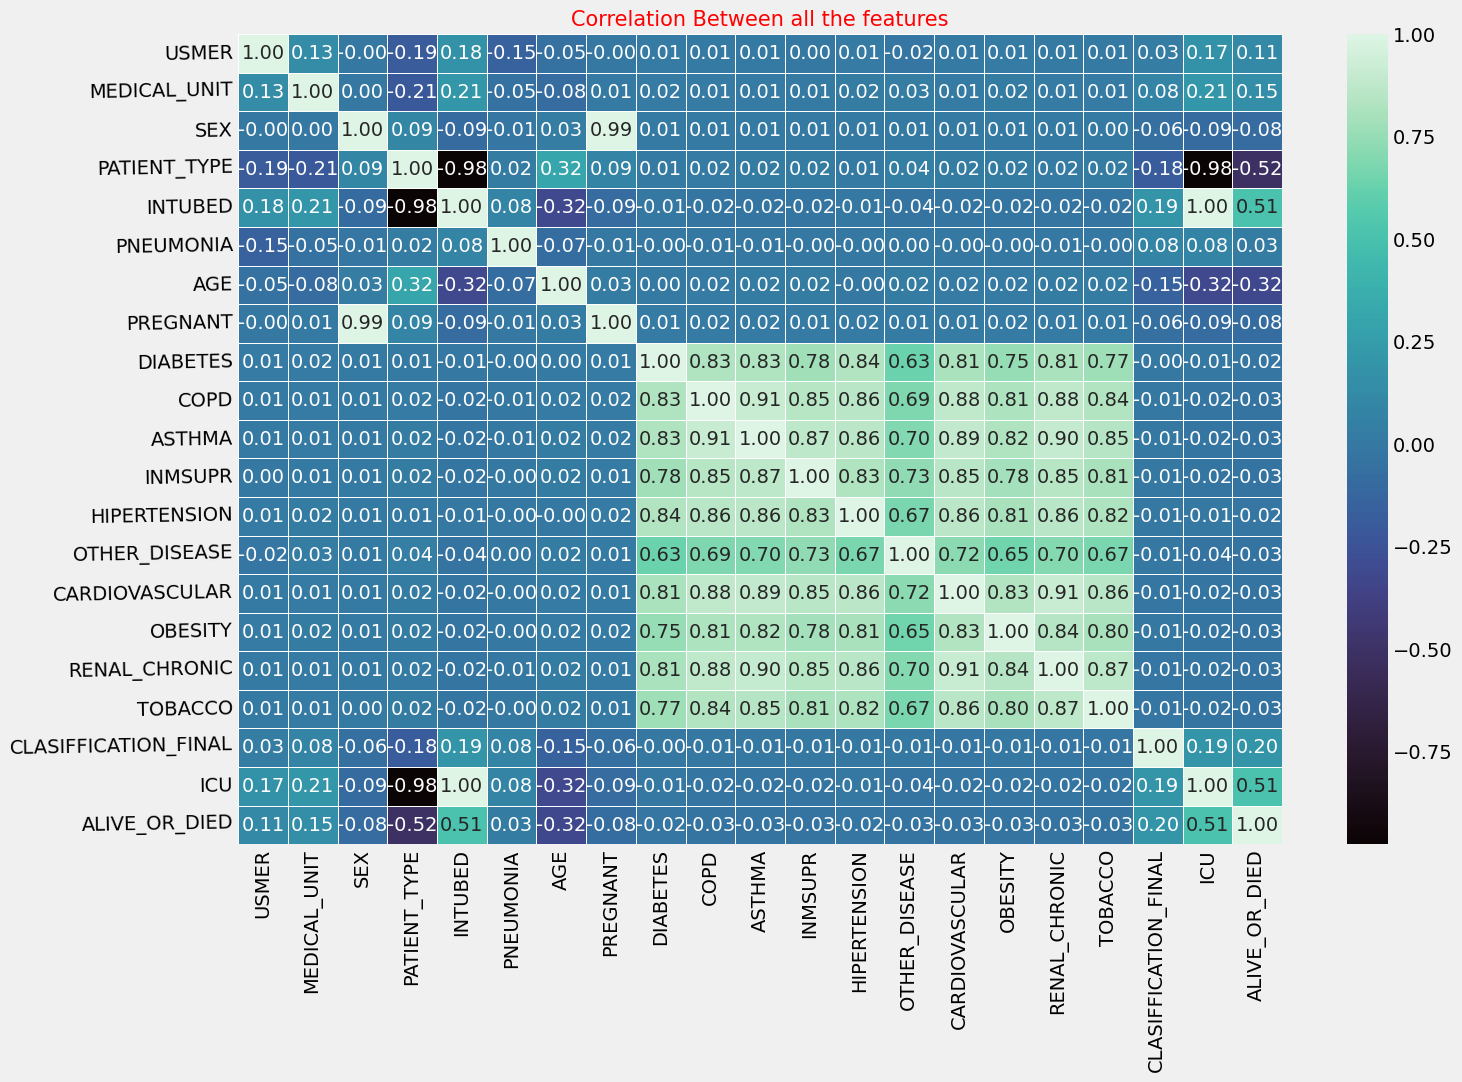

In [207]:
corr_matrix = df_covid.corr()

fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt=".2f",
                cmap="mako")
plt.yticks(rotation=1)
plt.title("Correlation Between all the features", fontsize=15, c='red');

In [208]:
cor_target = abs(corr_matrix["ALIVE_OR_DIED"])

features_selected = dict(cor_target[cor_target>0.1])
list_features_selected = list(features_selected.keys())
list_features_selected

['USMER',
 'MEDICAL_UNIT',
 'PATIENT_TYPE',
 'INTUBED',
 'AGE',
 'CLASIFFICATION_FINAL',
 'ICU',
 'ALIVE_OR_DIED']

In [209]:
X = df_covid
#X = df_covid[list_features_selected]

In [210]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
#clusters = hierarchy.linkage(X, method="ward")
#
#plt.figure(figsize=(10, 10))
#dendrogram = hierarchy.dendrogram(clusters)
## Plotting a horizontal line based on the first biggest distance between clusters 
#plt.axhline(150, color='red', linestyle='--'); 
## Plotting a horizontal line based on the second biggest distance between clusters 
#plt.axhline(100, color='crimson')

In [211]:
col_names = list(df_covid.columns)
col_names

['USMER',
 'MEDICAL_UNIT',
 'SEX',
 'PATIENT_TYPE',
 'INTUBED',
 'PNEUMONIA',
 'AGE',
 'PREGNANT',
 'DIABETES',
 'COPD',
 'ASTHMA',
 'INMSUPR',
 'HIPERTENSION',
 'OTHER_DISEASE',
 'CARDIOVASCULAR',
 'OBESITY',
 'RENAL_CHRONIC',
 'TOBACCO',
 'CLASIFFICATION_FINAL',
 'ICU',
 'ALIVE_OR_DIED']

In [212]:
scaler = MinMaxScaler()

df_covid_scaled = scaler.fit_transform(df_covid.to_numpy())
df_covid_scaled = pd.DataFrame(df_covid_scaled, columns=col_names)

In [213]:
columns = list()

items = random.randint(5, 21)
items

icount = 0
for col_name in col_names:
    if icount != items: 
        columns.append(col_name)
    else:
        break
    
    icount += 1
    
columns

['USMER',
 'MEDICAL_UNIT',
 'SEX',
 'PATIENT_TYPE',
 'INTUBED',
 'PNEUMONIA',
 'AGE',
 'PREGNANT',
 'DIABETES',
 'COPD',
 'ASTHMA',
 'INMSUPR',
 'HIPERTENSION',
 'OTHER_DISEASE',
 'CARDIOVASCULAR']

In [214]:
first = columns[0]
last = columns[-1]

first_index = columns.index(first)
last_index = columns.index(last)

print(f'first element: {first} and last element: {last}')
print(f'first index: {first_index} and last index: {last_index}')

first element: USMER and last element: CARDIOVASCULAR
first index: 0 and last index: 14


In [215]:
df_covid_reduced = df_covid_scaled

X = df_covid_reduced[columns].iloc[:, [first_index,last_index]].values
X

array([[1.        , 0.01030928],
       [1.        , 0.01030928],
       [1.        , 0.01030928],
       ...,
       [1.        , 0.01030928],
       [1.        , 0.01030928],
       [1.        , 0.01030928]])

In [216]:
kmeans_kwargs = {"init": "random",
                 "n_init": 10,
                 "max_iter": 300,
                 "random_state": 42,
                }

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_covid_scaled)
    sse.append(kmeans.inertia_)
    

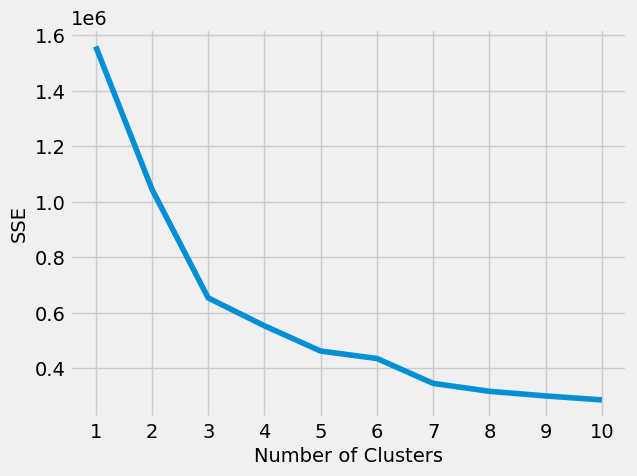

In [217]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [223]:
# Convert DataFrame to matrix
cmatrix = df_covid.values
# Using sklearn
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(cmatrix)
# Get cluster assignment labels
labels = kmeans.labels_
# Format results as a DataFrame
results = pd.DataFrame(data=labels, columns=['cluster'], index=df_covid.index)
results

###>>> STOP HERE - https://scikit-learn.org/stable/auto_examples/cluster/plot_inductive_clustering.html#sphx-glr-auto-examples-cluster-plot-inductive-clustering-py

/home/andsilva/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,cluster
0,1
1,2
2,0
3,1
4,2
...,...
1048570,2
1048571,0
1048572,2
1048573,2


In [224]:
results.nunique()

cluster    3
dtype: int64